In [3]:
# set cwd and solver
import os
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [4]:
import pandas as pd
from pathlib import Path
# load Lukowswki gene expression data 
Lukowski_gene_exp = pd.read_excel(Path().cwd().parent/ 'context_specific_models' / 'expression_data' / 'expression_data_Lukowski.xlsx')
# load Sysgo gene expression data 
Sysgo_gene_exp = pd.read_excel(Path().cwd().parent/ 'context_specific_models' / 'expression_data' / 'expression_data_SysGO_2020_RPE_PR.xlsx')

In [6]:
# select columns 'C10 Cone PR (%)' and Rod PR (%)' 
Lukowski_expr = Lukowski_gene_exp[['GeneSymbol','Ensembl','C10 Cone PR (%)','Average Rod PR C0, C1, C2, C3, C4, C7 (%)']]
Lukowski_expr.columns = ['GeneSymbol','Ensembl','Cone_Lukowski','Rod_Lukoswki'] # rename columns
Liang_expr = Sysgo_gene_exp[['GeneSymbol','Ensembl','ConePhotoreceptors__LiangEtAl_2019_','RodPhotoreceptors__LiangEtAl_2019_']]
Liang_expr.columns = ['GeneSymbol','Ensembl','Cone_Liang','Rod_Liang'] # rename columns

# merge Lukowski and Liang dfs
Lukowski_Liang_expr = pd.merge(Lukowski_expr, Liang_expr, on=['GeneSymbol','Ensembl'], how='inner')
# remove any rows with NaN values
Lukowski_Liang_expr_nonNaN = Lukowski_Liang_expr.dropna()
Lukowski_Liang_expr_nonNaN

,GeneSymbol,Ensembl,Cone_Lukowski,Rod_Lukoswki,Cone_Liang,Rod_Liang
1,A4GNT,ENSG00000118017,0.000000,0.000000,0.000000,0.000652
2,AAAS,ENSG00000094914,0.002994,0.002782,0.034887,0.041759
3,AACS,ENSG00000081760,0.001344,0.001137,0.117917,0.076511
5,AADAT,ENSG00000109576,0.000369,0.000563,0.020034,0.016466
6,AANAT,ENSG00000129673,0.000425,0.000385,0.117648,0.124430
...,...,...,...,...,...,...
3037,ZDHHC9,ENSG00000188706,0.000640,0.000263,0.036382,0.031007
3038,ZMPSTE24,ENSG00000084073,0.002317,0.001570,0.070642,0.072308
3039,ZNRD1,ENSG00000066379,0.003439,0.002697,0.044492,0.035282
3040,ZNRF1,ENSG00000186187,0.021722,0.000249,0.101025,0.041969


In [167]:
def discretize_data(df):
    import numpy as np
    import pandas as pd
    df_discretized = df.copy(deep=True)
    for c in df.columns[2:]:
        q25 = df_discretized[c].quantile([0.25]).values[0]
        q75 = df_discretized[c].quantile([0.75]).values[0]
        m1 = df_discretized.loc[:,c]<.00001
        m2 = df_discretized.loc[:,c].between(.00001, q25)
        m3 = df_discretized.loc[:,c].between(q25, q75)
        m4 = df_discretized.loc[:,c]> q75
        m5 = df_discretized.loc[:,c].isna()
        df_discretized[c] = np.select([m1, m2, m3, m4, m5], [-1,1,2,3,0], default=None)
    return df_discretized
    
Lukowski_exp_discretized = discretize_data(Lukowski_expr)
# remove rows that have nan for ensemble col
Lukowski_exp_discretized = Lukowski_exp_discretized[Lukowski_exp_discretized['Ensembl'].notna()]
Liang_expr_discretized  = discretize_data(Liang_expr)
# merge Lukowski and Liang dfs
Lukowski_Liang_expr_discretized = pd.merge(Lukowski_exp_discretized,Liang_expr_discretized, \
    on=['GeneSymbol','Ensembl'], how='inner')
Lukowski_Liang_expr_discretized

,GeneSymbol,Ensembl,Cone_Lukowski,Rod_Lukoswki,Cone_Liang,Rod_Liang
0,A4GALT,ENSG00000128274,-1,-1,0,0
1,A4GNT,ENSG00000118017,-1,-1,-1,1
2,AAAS,ENSG00000094914,3,3,2,2
3,AACS,ENSG00000081760,2,2,2,2
4,AADAC,ENSG00000114771,-1,-1,0,0
...,...,...,...,...,...,...
3038,ZMPSTE24,ENSG00000084073,2,2,2,2
3039,ZNRD1,ENSG00000066379,3,3,2,2
3040,ZNRF1,ENSG00000186187,3,2,2,2
3041,ZNRF2,ENSG00000180233,3,2,2,2


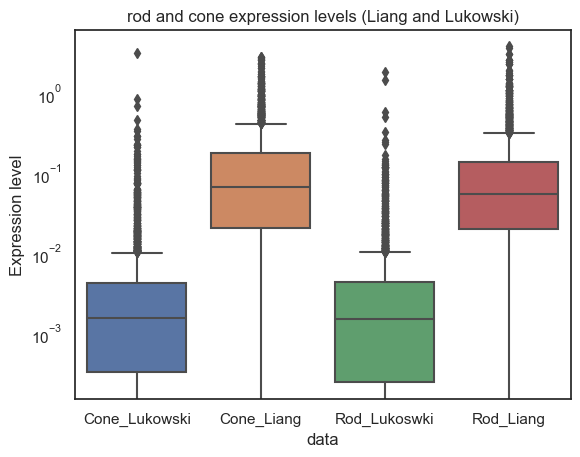

In [170]:
import seaborn as sns
# boxplots for Lukowski and Liang rods and cones
# make long dataset for boxplots
Lukowski_Liang_expr_nonNaN_long = pd.melt(Lukowski_Liang_expr_nonNaN, id_vars=['GeneSymbol','Ensembl'], value_vars=['Cone_Lukowski','Cone_Liang','Rod_Lukoswki','Rod_Liang'])
Lukowski_Liang_expr_nonNaN_long
ax = sns.boxplot(x="variable", y="value", data=Lukowski_Liang_expr_nonNaN_long)# make boxplot
ax.set(yscale="log") # log y scale
ax.set_title('rod and cone expression levels (Liang and Lukowski)')
ax.set(xlabel='data', ylabel='Expression level')

# save figure in results folder using savefig
if not os.path.exists('results/Liang_vs_Lukowski'):
    os.makedirs('results/Liang_vs_Lukowski')
plt.savefig(Path().cwd()/ 'results' / 'compare_rod_models' / 'Liang_vs_Lukowski' / 'boxplots_expression_log.png', dpi=300, bbox_inches='tight')

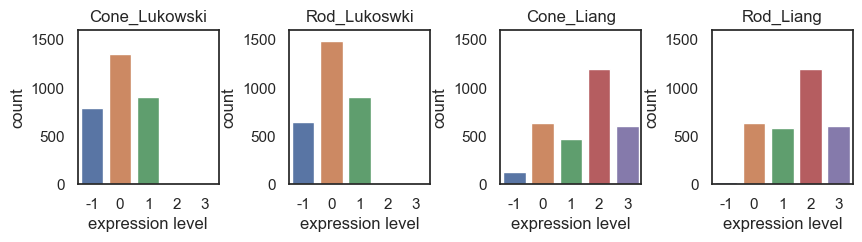

In [318]:
import seaborn as sns

# make long dataset for boxplots
Lukowski_Liang_expr_discretized_long = pd.melt(Lukowski_Liang_expr_discretized, id_vars=['GeneSymbol','Ensembl'], value_vars=['Cone_Lukowski','Cone_Liang','Rod_Lukoswki','Rod_Liang'])
#  frequency distributions for Lukowski and Liang rods and cones in subplots for each dataset

conditions = Lukowski_Liang_expr_discretized_long['variable'].unique()
# change order conditions lukowski first, liang second
conditions = ['Cone_Lukowski','Rod_Lukoswki','Cone_Liang','Rod_Liang']

#plot countplots with different conditions on different rows
fig, axes = plt.subplots(1, len(conditions), figsize=(10, 2), sharex=True)
for i in range(len(conditions)):
    condition = conditions[i]
    ax = sns.countplot(ax=axes[i], x="value", data=Lukowski_Liang_expr_discretized_long[Lukowski_Liang_expr_discretized_long['variable']==condition])
    ax.set_title(condition)
    ax.set(xlabel='expression level', ylabel='count')
    ax.set_ylim([0, 1600])
    # add space between subplots
    fig.subplots_adjust(wspace=0.5)

# save figure in results folder using savefig
if not os.path.exists('results/Liang_vs_Lukowski'):
    os.makedirs('results/Liang_vs_Lukowski')
plt.savefig(Path().cwd()/ 'results' / 'compare_rod_models' / 'Liang_vs_Lukowski' / 'countplots_expression.png', dpi=300, bbox_inches='tight')

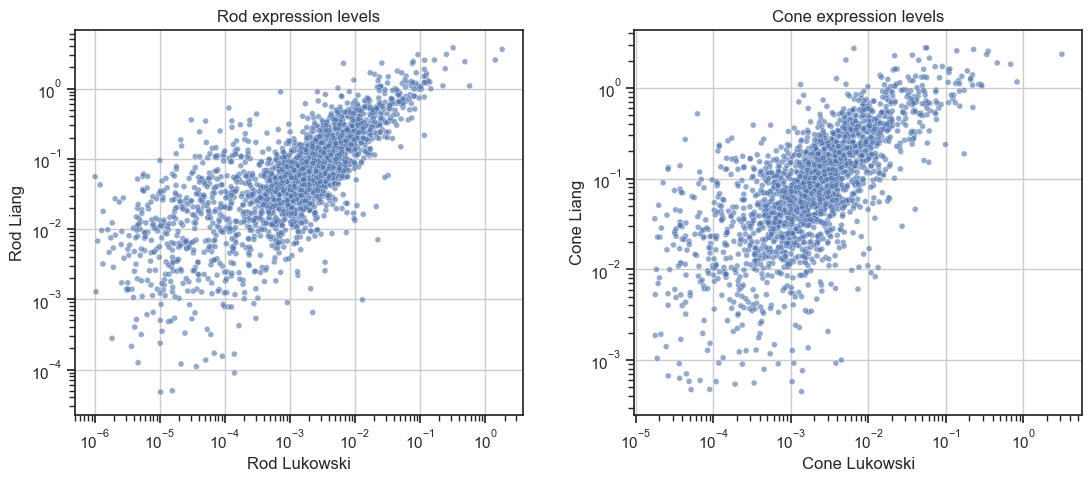

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_scatterplot_expression_data(ax, x, y, xlabel, ylabel, title, xscale='log', yscale='log', alpha=0.6, size=5):
    # create scatterplot using seaborn
    sns.scatterplot(ax=ax, x=x, y=y, alpha=alpha, size=size)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set(xscale=xscale, yscale=yscale)
    
    # Set log minor ticks
    if xscale == 'log':
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))
    if yscale == 'log':
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))

    ax.grid(True, which='major')  # Grid for both major and minor ticks
    ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
    
    ax.get_legend().remove()
    ax.set_title(title)


# subplots for Lukowski and Liang rods and cones
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# plot Lukowski rods vs Liang rods scatterplot
make_scatterplot_expression_data(ax=axs[0], \
    x=Lukowski_Liang_expr_nonNaN['Rod_Lukoswki'], \
    y=Lukowski_Liang_expr_nonNaN['Rod_Liang'],\
    xlabel='Rod Lukowski', ylabel='Rod Liang',\
    title='Rod expression levels')
    
# plot Lukowski rods vs Liang rods scatterplot
make_scatterplot_expression_data(ax=axs[1], \
    x=Lukowski_Liang_expr_nonNaN['Cone_Lukowski'], \
    y=Lukowski_Liang_expr_nonNaN['Cone_Liang'],\
    xlabel='Cone Lukowski', ylabel='Cone Liang',\
    title='Cone expression levels')

# increase space between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.25)

# save figure in results folder using savefig
if not os.path.exists('results/Liang_vs_Lukowski'):
    os.makedirs('results/Liang_vs_Lukowski')
plt.savefig(Path().cwd()/ 'results' /  'Liang_vs_Lukowski' / 'scatterplots_expression.png', dpi=300, bbox_inches='tight')

In [229]:
##### FOR DISCRETISED DATASET #####

# make a correlation plot for Rod_Lukoswki and Rod_Liang with colours for the percentage of datapoints in each combination
# sns.heatmap(dataframe.correlation)
# make numeric only
Lukowski_Liang_expr_discretized_numeric_rod = Lukowski_Liang_expr_discretized[['Rod_Lukoswki','Rod_Liang']].apply(pd.to_numeric)
Lukowski_Liang_expr_discretized_numeric_cone = Lukowski_Liang_expr_discretized[['Cone_Lukowski','Cone_Liang']].apply(pd.to_numeric)
# make contingency table
contingency_table_rod = pd.crosstab(Lukowski_Liang_expr_discretized_numeric_rod['Rod_Lukoswki'], Lukowski_Liang_expr_discretized_numeric_rod['Rod_Liang'])
contingency_table_rod

Rod_Liang,-1,0,1,2,3
Rod_Lukoswki,,,,,
-1,8,466,140,32,2
2,12,147,423,820,86
3,0,27,18,349,513


In [232]:
# make contingency table for cones
contingency_table_cone = pd.crosstab(Lukowski_Liang_expr_discretized_numeric_cone['Cone_Lukowski'], Lukowski_Liang_expr_discretized_numeric_cone['Cone_Liang'])
contingency_table_cone

Cone_Liang,-1,0,1,2,3
Cone_Lukowski,,,,,
-1,77,500,140,69,4
2,53,113,305,795,85
3,1,27,25,337,512


In [298]:
# make contingency table for Lukowski rods vs cones
contingency_table_Lukowski = pd.crosstab(Lukowski_Liang_expr_discretized_numeric_rod['Rod_Lukoswki'], Lukowski_Liang_expr_discretized_numeric_cone['Cone_Lukowski'])
contingency_table_Lukowski

Cone_Lukowski,-1,2,3
Rod_Lukoswki,,,
-1,577,70,1
2,213,1150,125
3,0,131,776


In [299]:
# make contingency table for Liang rods vs cones
contingency_table_Liang = pd.crosstab(Lukowski_Liang_expr_discretized_numeric_rod['Rod_Liang'], Lukowski_Liang_expr_discretized_numeric_cone['Cone_Liang'])
contingency_table_Liang

Cone_Liang,-1,0,1,2,3
Rod_Liang,,,,,
-1,13,0,7,0,0
0,0,640,0,0,0
1,117,0,353,111,0
2,1,0,110,1003,87
3,0,0,0,87,514


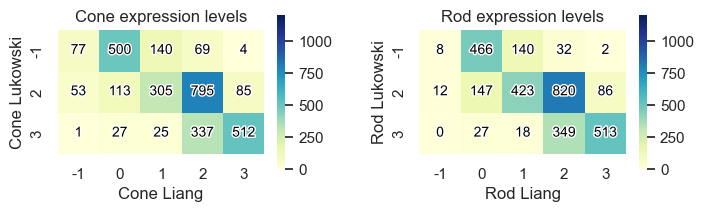

In [322]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects

# subplots for rod and cone contingency tables
fig, axs = plt.subplots(1, 2, figsize=(8,2))
# plot Cone Lukowski vs Cone Liang heatmap on the left
sns.heatmap(contingency_table_cone, annot=False, cmap="YlGnBu", ax=axs[0])
axs[0].collections[0].set_clim(0, 1200)
axs[0].set_aspect('equal', adjustable='box')
# add annotation (values to boxes)for all boxes
for i in range(len(contingency_table_cone.index)):
    for j in range(len(contingency_table_cone.columns)):
        text = axs[0].text(j + 0.5, i + 0.5, contingency_table_cone.iloc[i, j], ha="center", va="center", color="black",fontsize=10)
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white')])

axs[0].set_xlabel('Cone Liang')
axs[0].set_ylabel('Cone Lukowski')
axs[0].set_title('Cone expression levels')

# plot Rod Lukowski vs Rod Liang heatmap on the right
sns.heatmap(contingency_table_rod, annot=False, cmap="YlGnBu", ax=axs[1])
axs[1].collections[0].set_clim(0, 1200)
axs[1].set_aspect('equal', adjustable='box')
# add annotation (values to boxes)for all boxes
for i in range(len(contingency_table_rod.index)):
    for j in range(len(contingency_table_rod.columns)):
        text = axs[1].text(j + 0.5, i + 0.5, contingency_table_rod.iloc[i, j], ha="center", va="center", color="black",fontsize=10)
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white')])
axs[1].set_xlabel('Rod Liang')
axs[1].set_ylabel('Rod Lukowski')
axs[1].set_title('Rod expression levels')

# increase space between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# save figure in results folder using savefig
if not os.path.exists('results/Liang_vs_Lukowski'):
    os.makedirs('results/Liang_vs_Lukowski')
plt.savefig(Path().cwd()/ 'results' / 'compare_rod_models' / 'Liang_vs_Lukowski' / 'contingency_tables_Cone_vs_Rod.png', dpi=300, bbox_inches='tight')


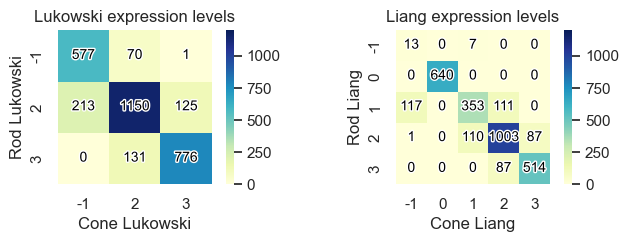

In [324]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects

# subplots for Lukowski and Liang contingency tables
fig, axs = plt.subplots(1, 2, figsize=(8,2))
# plot Cone Lukowski vs Cone Liang heatmap on the left
sns.heatmap(contingency_table_Lukowski, annot=False, cmap="YlGnBu", ax=axs[0])
axs[0].collections[0].set_clim(0, 1200)
axs[0].set_aspect('equal', adjustable='box')
# add annotation (values to boxes)for all boxes
for i in range(len(contingency_table_Lukowski.index)):
    for j in range(len(contingency_table_Lukowski.columns)):
        text = axs[0].text(j + 0.5, i + 0.5, contingency_table_Lukowski.iloc[i, j], ha="center", va="center", color="black",fontsize=10)
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white')])
axs[0].set_xlabel('Cone Lukowski')
axs[0].set_ylabel('Rod Lukowski')
axs[0].set_title('Lukowski expression levels')

# plot Rod Lukowski vs Rod Liang heatmap on the right
sns.heatmap(contingency_table_Liang, annot=False, cmap="YlGnBu", ax=axs[1])
axs[1].collections[0].set_clim(0, 1200)
axs[1].set_aspect('equal', adjustable='box')
# add annotation (values to boxes)for all boxes
for i in range(len(contingency_table_Liang.index)):
    for j in range(len(contingency_table_Liang.columns)):
        text = axs[1].text(j + 0.5, i + 0.5, contingency_table_Liang.iloc[i, j], ha="center", va="center", color="black",fontsize=10)
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white')])
axs[1].set_xlabel('Cone Liang')
axs[1].set_ylabel('Rod Liang')
axs[1].set_title('Liang expression levels')

# increase space between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.2)


# save figure in results folder using savefig
if not os.path.exists('results/Liang_vs_Lukowski'):
    os.makedirs('results/Liang_vs_Lukowski')
plt.savefig(Path().cwd()/ 'results' / 'compare_rod_models' / 'Liang_vs_Lukowski' / 'contingency_tables_Lukowski_vs_Liang.png', dpi=300, bbox_inches='tight')



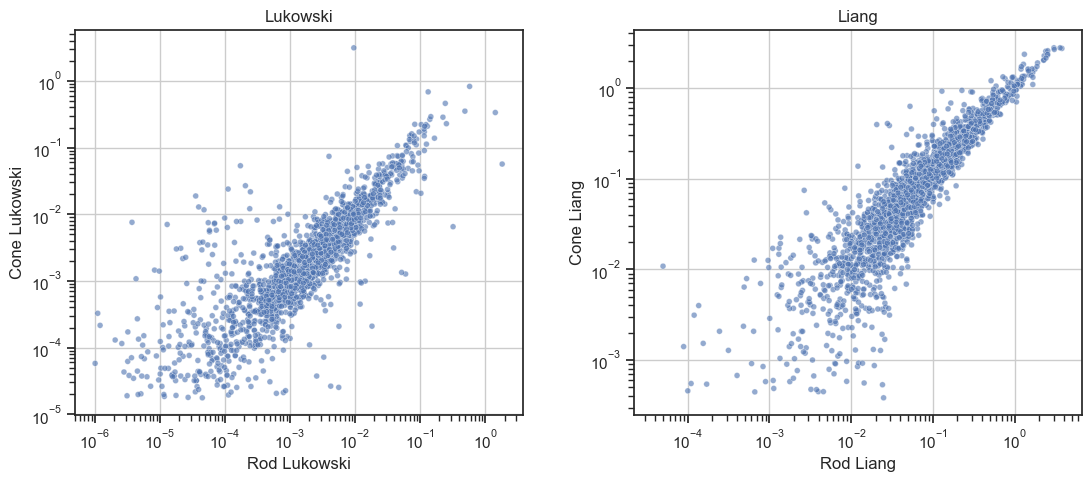

In [164]:
###### RODS VS CONES ######

# plot Lukowski (0) and Liang (1) rods vs cones scatterplot
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# plot Lukowski rods vs Liang rods scatterplot
make_scatterplot_expression_data(ax=axs[0], \
    x=Lukowski_Liang_expr_nonNaN['Rod_Lukoswki'], \
    y=Lukowski_Liang_expr_nonNaN['Cone_Lukowski'],\
    xlabel='Rod Lukowski', ylabel='Cone Lukowski',\
    title='Lukowski')

# plot Lukowski rods vs Liang rods scatterplot
make_scatterplot_expression_data(ax=axs[1], \
    x=Lukowski_Liang_expr_nonNaN['Rod_Liang'], \
    y=Lukowski_Liang_expr_nonNaN['Cone_Liang'],\
    xlabel='Rod Liang', ylabel='Cone Liang',\
    title='Liang')

# increase space between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.25)

# save figure in results folder using savefig
if not os.path.exists('results/Liang_vs_Lukowski'):
    os.makedirs('results/Liang_vs_Lukowski')
plt.savefig(Path().cwd()/ 'results' / 'compare_rod_models' / 'Liang_vs_Lukowski' / 'scatterplots_expression_rods_vs_cones.png', dpi=300, bbox_inches='tight')

In [120]:
# load pickle Path().cwd() / 'results' / 'compare_rod_models' / 'fva_Lukowski_diff.pkl'
import pickle
with open(Path().cwd() / 'results' / 'compare_rod_models' / 'fva_Lukowski_diff.pkl', 'rb') as f:
    fva_Lukowski_diff = pickle.load(f)
df = fva_Lukowski_diff
df

,min,max,min_modified,max_modified,min_loopless,max_loopless,min_loopless_modified,max_loopless_modified,cell,lb,...,bigg.reaction,sbo,rhea,vmhreaction,kegg.reaction,name,subsystem,reaction,met_IDs,GPR
MAR06328_PR,16.65,1000.0,16.65,16.65,16.65,16.65,16.65,16.65,PR,-1000.0,...,ATPtm,SBO:0000185,"[35002, 34999]",ATPtm,R00124,ATP:ADP phosphatransferase,Transport reactions,ADP[c_PR] + ATP[m_PR] <=> ADP[m_PR] + ATP[c_PR],MAM01285c_PR + MAM01371m_PR <=> MAM01285m_PR +...,ENSG00000005022 or ENSG00000151729 or ENSG0000...
MAR05648_PR_RPE,0.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,,SBO:0000185,,r1733,,,Transport reactions,alanine[c_PR] + methionine[e_RPE_PR] + Na+[e_R...,MAM01307c_PR + MAM02471e_RPE_PR + MAM02519e_RP...,ENSG00000103064 or ENSG00000103257
MAR05664_PR_RPE,0.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,,SBO:0000185,,r1749,,,Transport reactions,glutamine[c_PR] + Na+[e_RPE_PR] + tryptophan[e...,MAM01975c_PR + MAM02519e_RPE_PR + MAM03089e_RP...,ENSG00000103064 or ENSG00000103257
MAR05663_PR_RPE,0.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,,SBO:0000185,,r1748,,,Transport reactions,alanine[c_PR] + Na+[e_RPE_PR] + tryptophan[e_R...,MAM01307c_PR + MAM02519e_RPE_PR + MAM03089e_RP...,ENSG00000103064 or ENSG00000103257
MAR05662_PR_RPE,0.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,,SBO:0000185,,r1747,,,Transport reactions,glycine[c_PR] + Na+[e_RPE_PR] + tryptophan[e_R...,MAM01986c_PR + MAM02519e_RPE_PR + MAM03089e_RP...,ENSG00000103064 or ENSG00000103257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR05530_PR_RPE,-1000.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,,SBO:0000185,,r1615,,,Transport reactions,threonine[c_PR] + tryptophan[e_RPE_PR] --> thr...,MAM02993c_PR + MAM03089e_RPE_PR --> MAM02993e_...,ENSG00000103257 or ENSG00000165029
MAR05529_PR_RPE,-1000.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,,SBO:0000185,,r1614,,,Transport reactions,tryptophan[c_PR] + valine[e_RPE_PR] --> trypto...,MAM03089c_PR + MAM03135e_RPE_PR --> MAM03089e_...,ENSG00000103257 or ENSG00000165029
MAR11571_PR_RPE,-1000.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,3AIBSYMPt,SBO:0000185,,3AIBSYMPt,,"3-Amino-Isobutyrate Transport, Sodium Symport",Transport reactions,L-3-amino-isobutanoate[e_RPE_PR] + 2.0 Na+[e_R...,MAM02325e_RPE_PR + 2.0 MAM02519e_RPE_PR --> MA...,
MAR05528_PR_RPE,-1000.00,1000.0,0.00,0.00,0.00,0.00,0.00,0.00,RPE,0.0,...,,SBO:0000185,,r1613,,,Transport reactions,asparagine[c_PR] + tryptophan[e_RPE_PR] --> as...,MAM01369c_PR + MAM03089e_RPE_PR --> MAM01369e_...,ENSG00000103257 or ENSG00000165029
